# Import Necessary Library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv('Product_review.csv')
print(df.shape)
df = df.head(50000)
print(df.shape)

(982619, 10)
(50000, 10)


In [3]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


# Drop unnecessary columns 
   ### After that rename columns of dataframe

In [4]:
data1 = df.drop(['asin','helpful','reviewTime','reviewerID','reviewerName','unixReviewTime','summary'],axis=1)

In [5]:
data1.head()

,Unnamed: 0,overall,reviewText
0,0,5,I enjoy vintage books and movies so I enjoyed ...
1,1,4,This book is a reissue of an old one; the auth...
2,2,4,This was a fairly interesting read. It had ol...
3,3,5,I'd never read any of the Amy Brewster mysteri...
4,4,4,"If you like period pieces - clothing, lingo, y..."


In [6]:
data1.rename(columns = {'Unnamed: 0':'ID','overall':'Ratings'}, inplace = True)


In [7]:
data1

,ID,Ratings,reviewText
0,0,5,I enjoy vintage books and movies so I enjoyed ...
1,1,4,This book is a reissue of an old one; the auth...
2,2,4,This was a fairly interesting read. It had ol...
3,3,5,I'd never read any of the Amy Brewster mysteri...
4,4,4,"If you like period pieces - clothing, lingo, y..."
...,...,...,...
49995,49995,5,Anne Marie Novark has done it again. Book 3 in...
49996,49996,4,This goes to show just how much hurt losing yo...
49997,49997,4,Despite the physical beauty of Novark's charac...
49998,49998,4,"I have enjoyed this series, and will continue ..."


## Check is there any null values in dataset
   #### Remove null values by fillna function and mentioned no data  insted of null values


In [8]:
data1.isnull().sum()

ID            0
Ratings       0
reviewText    1
dtype: int64

In [9]:
data1["reviewText"].fillna("No data", inplace = True)


In [10]:
data1.isnull().sum()

ID            0
Ratings       0
reviewText    0
dtype: int64

# Wordcloud for review text data

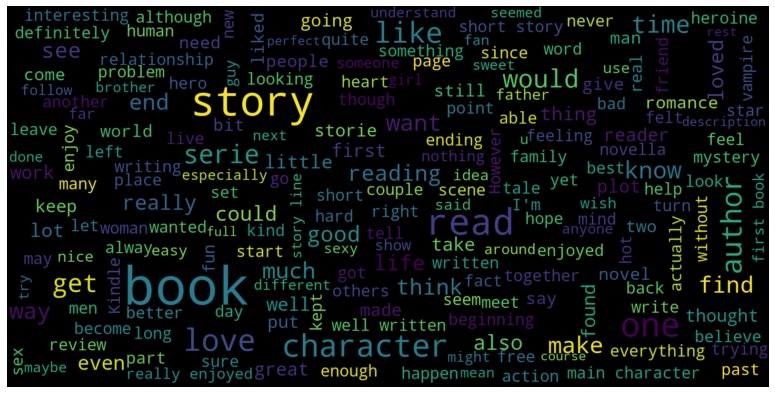

In [11]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import numpy as np
from PIL import Image


text = "".join(i for i in data1.reviewText)
stopwords = set(stopwords.words("english"))

wordcloud = WordCloud(stopwords=stopwords, background_color="black",width=1600,height=800,random_state=21,max_font_size=110).generate(text)
plt.figure( figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Bar graph for ratings out of 5 stars 

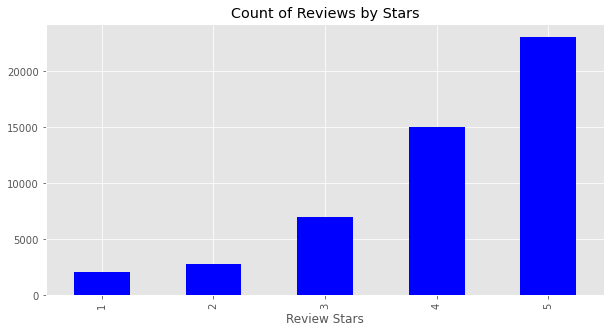

In [12]:
ax = data1['Ratings'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5),
         color="blue")
ax.set_xlabel('Review Stars')
plt.show()

# Import library for sentiment analysis

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

## Check polarity score of given text 
 ### It lies between -1 to +1
 
 ### If it is <1 then it would be negative review
 
 ### If it is >1 then it would be positive review
 
  ### If it is =0 then it would be neutral review

In [14]:
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [15]:
sia.polarity_scores("not as advertised ")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [16]:
sia.polarity_scores("Product is delicious and attractive")

{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.765}

## Using tqdm iterate each rows and find polarity scores of entire data

In [17]:
res = {}
for i, row in tqdm(data1.iterrows(), total=len(data1)):
    text = row['reviewText']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

# VADERS ((Valence Aware Dictionary and Sentiment Reasoner)
   ### VADER is commonly used in natural language processing (NLP) and text mining tasksto determine the sentiment or emotional tone of a piece of text

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders = vaders.merge(data1, how='left')

##  Assign label to compound polarity scores according to positive , negative and neutral
#### Add new column named    " sentiment" 

In [19]:
def sentiment(label):
    if label<0:
        return "Negative"
    elif label==0:
        return "Neutral"
    elif label>0:
        return "positive"

In [20]:
vaders['sentiment'] = vaders['compound'].apply(sentiment)

In [21]:
vaders.head(10)


,ID,neg,neu,pos,compound,Ratings,reviewText,sentiment
0,0,0.000,0.809,0.191,0.8698,5,I enjoy vintage books and movies so I enjoyed ...,positive
1,1,0.050,0.775,0.175,0.8622,4,This book is a reissue of an old one; the auth...,positive
2,2,0.000,0.741,0.259,0.9501,4,This was a fairly interesting read. It had ol...,positive
3,3,0.000,1.000,0.000,0.0000,5,I'd never read any of the Amy Brewster mysteri...,Neutral
4,4,0.000,0.787,0.213,0.6908,4,"If you like period pieces - clothing, lingo, y...",positive
5,5,0.070,0.728,0.203,0.6369,4,A beautiful in-depth character description mak...,positive
6,6,0.051,0.681,0.267,0.8041,4,I enjoyed this one tho I'm not sure why it's c...,positive
7,7,0.128,0.829,0.042,-0.5799,4,Never heard of Amy Brewster. But I don't need ...,Negative
8,8,0.195,0.542,0.264,0.2263,5,Darth Maul working under cloak of darkness com...,positive
9,9,0.089,0.773,0.138,0.1397,4,This is a short story focused on Darth Maul's ...,positive


### Bar plot for compound score 

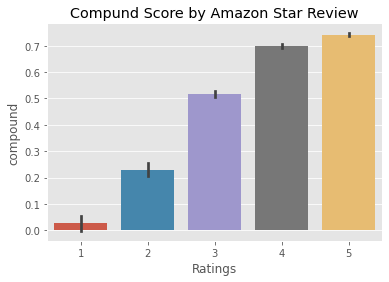

In [22]:
ax = sns.barplot(data=vaders, x='Ratings', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

### Bar plot according to reviews 

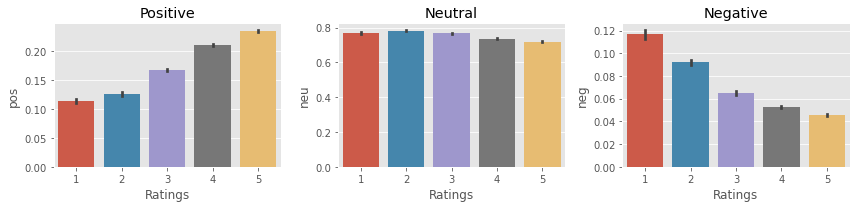

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Ratings', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Ratings', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Ratings', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Bar plot for positive , negative and neutral reviews

<AxesSubplot:xlabel='sentiment', ylabel='count'>

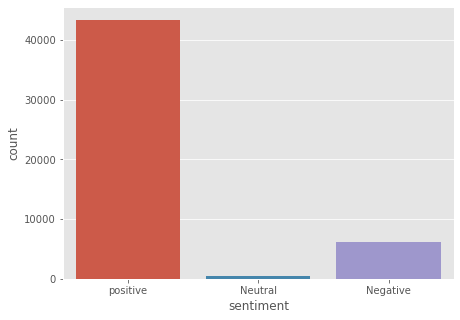

In [24]:
figure = plt.figure(figsize=(7,5))
sns.countplot(x="sentiment",data=vaders)

## Pie chart describes the percentage of positive , negative and neutral reviews 

<AxesSubplot:ylabel='sentiment'>

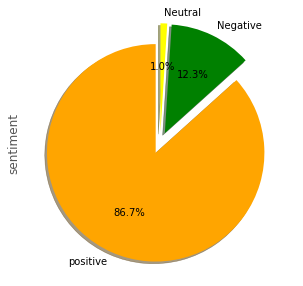

In [26]:
figure = plt.figure(figsize=(10,5))
colors = ("orange","green",'yellow')
wp = {"linewidth":2 , 'edgecolor':"black"}
tags = vaders["sentiment"].value_counts()
explode = (0.1,0.1,0.1)

tags.plot(kind='pie',shadow=True, colors = colors,
         startangle=90  ,explode=explode,
         autopct="%1.1f%%")

### Wordcloud for positive reviews 

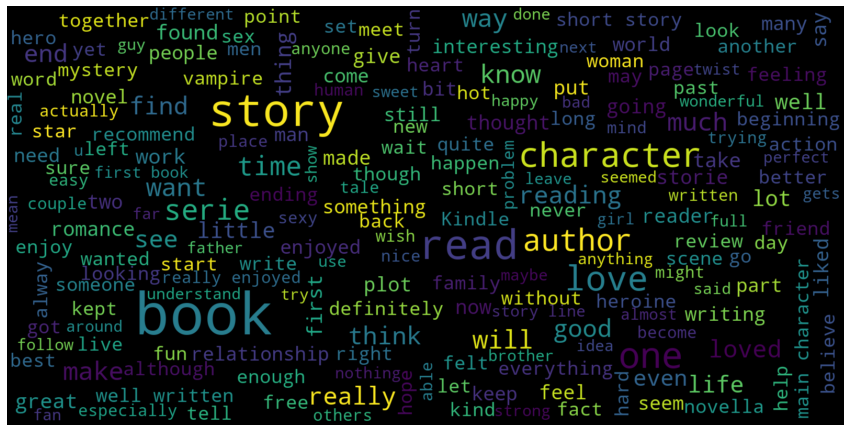

In [27]:
consolidated=' '.join(word for word in vaders['reviewText'][vaders['compound']>0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()


### Word cloud for negative reviews 

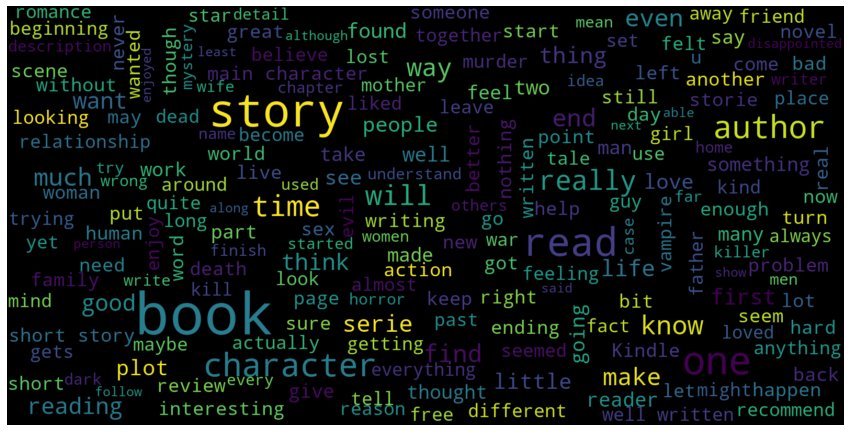

In [28]:
consolidated=' '.join(word for word in vaders['reviewText'][vaders['compound']<0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()


# Code for machine learning model 
## Predict positive,Negative and neutral sentiment 
### Model : RandomForest 
### Text preprocessing : CountVectorizer

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

In [30]:
cv = CountVectorizer(max_features=100)

In [31]:
X = vaders['reviewText']
y= vaders['sentiment']
X = cv.fit_transform(X).toarray()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Size of train and test data

In [33]:
print("size of X_train",(X_train.shape))
print("size of X_test",(X_test.shape))
print("size of y_train",(y_train.shape))
print("size of y_test",(y_test.shape))

size of X_train (35000, 100)
size of X_test (15000, 100)
size of y_train (35000,)
size of y_test (15000,)


In [34]:
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Test the classifier on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate model accuracy

In [36]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("accuracy is : {:.2f}%".format(accuracy*100))




accuracy is : 86.74%


In [37]:
print( conf_matrix)

[[   41     0  1802]
 [    0     0   167]
 [   20     0 12970]]


## ConfusionMatrix display the accuracy of model 

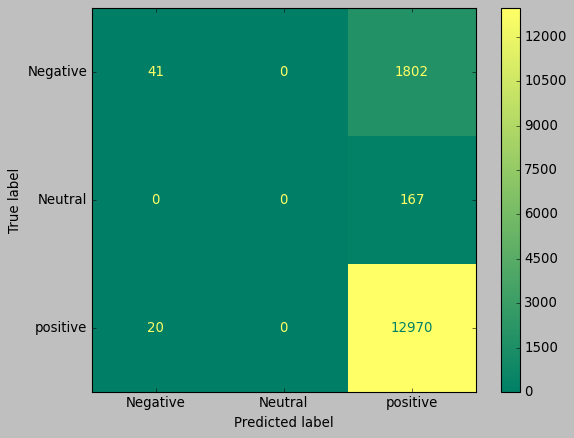

In [38]:
from matplotlib import style
style.use("classic")
cm = confusion_matrix(y_test,y_pred,labels=rf_classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_ )
disp.plot(cmap="summer",colorbar=True)

# Save the model into device for later used on test data

In [84]:
import joblib
file_name = "random_forest_model"
joblib.dump(rf_classifier,file_name)

['random_forest_model']